# Climate data bias correction in the cloud environment
The document demonstrates how to get climate climate model data from online website and make their ensemble. Then extract data for desired point/points/boundary, implement bias correction, compute several statistics to evaluate bias corrected data, visualize data in different temporal graphs. 

## Intorduction to climate model ensemble and its bias correction. 
Downloading and processing of climate models are a tedious task that can take sigfniciant time. Especailly, if the user is interested in evaluating ensemble of multiple models because each model has to be downloaded and processed seperately. In addition, storing and archiving data from multiple models requires significant storage hardware, it is not easy to transfer this data from one machine to the other either. Even after downloading and storing this data, combining them to an ensemble requires additional workflow and hard drive memory. 

To overcome above-mentioned challenges, this manual applies open-source python packages to retrieve and process climate data from OPenDAP over the cloud. The optimum advantage of the method is that we first access to the climate data servers and filter data to our particular region of interest (either a single point or boundary). This way data volume reduce sufficiently and the post processing can be performed faster. Therefore, unlike the usual data downloading/processing, one does not need to process data of a model for the entire globe (GCM) or a domain (RCM).  

As a practical example, the document shows how to process historical pr for Baguio meteo sation, from an ensemble (3 models) of RCM-SEA. In doing this, inteneded user first needs to define several parameters for the data they want, such as domain, variable, time frequency, ensemble, model and so on. It is also needed to specify coordinate or region to process the data. Then using xarray, climate data will be subset for the region of interest.

After data from multiple model is acquired, they have to be combined into an ensemble. The resulting ensemble needs bias adjustment. Here, several bias correction methods, available in the xclim package, applied to remove bias in the data. In the end, accuracy of bias adjusted data is also evaluated 


## Importing required python packages
Before proceeding, the some packages have to be installed in your local machine, anaconda environment. Then import the packages as below. 

In [2]:
import glob
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import xarray as xr
import xclim as xc
from xclim import sdba
from xclim import ensembles
import xskillscore as xs
import requests

In [3]:
def drkz_search(server="http://esgf-data.dkrz.de/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CORDEX",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

## Getting RCM data and making ensemble
Now the we defined the function. Use the function to to filter all RCM daily pr for SEA domain and ensemble r1i1p1.


In [31]:
rcm = drkz_search(project='CORDEX', variable='pr', domain = 'SEA-22',experiment='historical',time_frequency='day',ensemble='r1i1p1')

http://esgf-data.dkrz.de/esg-search/search/?variable=pr&domain=SEA-22&experiment=historical&time_frequency=day&ensemble=r1i1p1&project=CORDEX&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&domain=SEA-22&experiment=historical&time_frequency=day&ensemble=r1i1p1&project=CORDEX&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&domain=SEA-22&experiment=historical&time_frequency=day&ensemble=r1i1p1&project=CORDEX&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20


In the following data is printed to see the number of models and data period, which shows three RCM models having historical data over 1970-2005. Then open the one of the files and explore metadata such as longtitude, latiture, time and other variables of the data. 

In [4]:
rcm

['http://esgf1.dkrz.de/thredds/dodsC/cordex/cordex/output/SEA-22/GERICS/MOHC-HadGEM2-ES/historical/r1i1p1/GERICS-REMO2015/v1/day/pr/v20191015/pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-19701230.nc',
 'http://esgf1.dkrz.de/thredds/dodsC/cordex/cordex/output/SEA-22/GERICS/MOHC-HadGEM2-ES/historical/r1i1p1/GERICS-REMO2015/v1/day/pr/v20191015/pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_GERICS-REMO2015_v1_day_19710101-19751230.nc',
 'http://esgf1.dkrz.de/thredds/dodsC/cordex/cordex/output/SEA-22/GERICS/MOHC-HadGEM2-ES/historical/r1i1p1/GERICS-REMO2015/v1/day/pr/v20191015/pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_GERICS-REMO2015_v1_day_19760101-19801230.nc',
 'http://esgf1.dkrz.de/thredds/dodsC/cordex/cordex/output/SEA-22/GERICS/MOHC-HadGEM2-ES/historical/r1i1p1/GERICS-REMO2015/v1/day/pr/v20191015/pr_SEA-22_MOHC-HadGEM2-ES_historical_r1i1p1_GERICS-REMO2015_v1_day_19810101-19851230.nc',
 'http://esgf1.dkrz.de/thredds/dodsC/cordex/cordex/output/SEA-22/GERICS/

Now open the first file data and check metadata which is needed for data extraction later. For example, reading name of varaibles including lon, lat, precipition (pr), and time. This might be different for each model, then every models needs to be checked, in this case all models have same variable names and attributes. 

In [5]:
#open first data file to see variables
xr.open_dataset(rcm[0])


<xarray.Dataset>
Dimensions:                     (time: 360, bnds: 2, rlat: 201, rlon: 273,
                                 vertices: 4)
Coordinates:
  * time                        (time) object 1970-01-01 12:00:00 ... 1970-12...
  * rlat                        (rlat) float64 -16.06 -15.84 ... 27.72 27.94
  * rlon                        (rlon) float64 88.16 88.38 88.6 ... 147.8 148.0
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) object ...
    rotated_latitude_longitude  int32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    pr                          (time, rlat, rlon) float32 ...
Attributes: (12/35)
    institution:                     Helmholtz-Zentrum Geesthacht, Climate Se...
    institute_id:                    GERICS
    experiment_id:                   historical
    source:                          GERICS-REMO2015
    model_id:                        GERICS-REMO2015
    forcing:                         N/A
    ...                              ...
    parent_experiment:               N/A
    modeling_realm:                  atmos
    realization:                     1
    cmor_version:                    2.9.1
    tracking_id:                     hdl:21.14103/364c5e31-1c69-48de-8ee0-fd4...
    DODS_EXTRA.Unlimited_Dimension:  time

### Subsetting RCM data
Now we know the variables and metadata. Using this information we will extract data according to a point, a rainfall gauge station located in Baguio, Benguet. Here pr will be extracted for the whole historical available data (1970-2005), from all three models, for the the given coordinate.


In [32]:
y=16.4 #Define latitue (baguio station).
x=120.6 #Define longitude (baguio station).
unit = 'mm/day' #Define the unit for which data to be changed into.
var = 'pr' # Define variable

ds = []
for i in rcm:
    data = xr.open_dataset(i)
    data = data.assign_coords({'model_id':data.driving_model_id}) #add a new dimension to retrieve each model seperately later.
    data=data.sel(rlat=y,rlon=x,method='nearest') #check metadata of data, change this name (lon/lat) if needed.
    #ds.append(data['pr'])
    data = xc.units.convert_units_to(data[var], unit) # changing unit to mm/day
    ds.append(data)

### Making ensemble of RCM models
Now data from all models are filtered to the given geographic location. To make ensemble of each model, calendar of all models should be same. Also, spatial resolution has to be same. If it is different, then those models need to be regridded to a common spatial resolution where each model has the same resolution. In this sample dataset all models have same spatial resolution, meaning no spatial regridding is required. We only change the calendar to gregorian and fill the missing dates with zeros. This data will be referred to as RCM ensemble in the successive steps.  


In [33]:
dn = []
for i in ds:
    da = i.convert_calendar('gregorian', align_on='year',missing=0)
    dn.append(da)

/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in f

Next we make an xarray dataset by concatenating along the model dimension. This will make an xarray dataset that store pr of each model along the time dimension as shown below. After making this array, we can average output of the three models in order to make an ensemble.   

In [34]:
ens = xr.concat(dn, dim='model_id').rename('pr').to_dataset() #making an xarray dataset to store pr of each model
ens = ens.groupby('model_id').sum() #this is to avoid repeated coordinate
ens_mean = ens.mean(dim='model_id',keep_attrs=True) #average of each model


To check the individual model and their ensemble (mean), the interannual variability is plotted as below.This enemble model will be used for bias correction later. 

Text(0.5, 1.0, 'Intern-annual variability for each model and their ensemble')

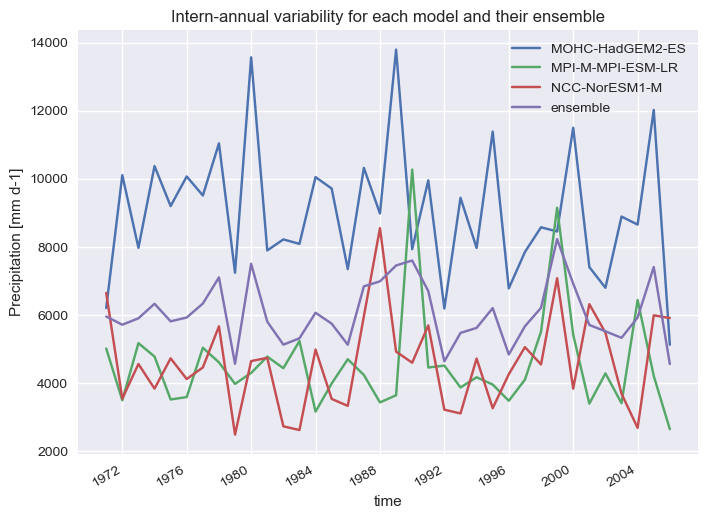

In [35]:
ens.resample(time='y').sum().pr.plot(hue='model_id',label=['MOHC-HadGEM2-ES', 'MPI-M-MPI-ESM-LR', 'NCC-NorESM1-M'])
ens_mean.resample(time='y').sum().pr.plot(label='ensemble')
plt.legend(frameon=False)
plt.title('Intern-annual variability for each model and their ensemble',fontsize=12)

## Uploading and formating observed data
In the second stage, it is needed to take a sample observed dataset and formatted according to an xarray dataarray. As example, daily rainfall from Baguio Benguet station (1981-2010) is used here. First read this data in a dataframe from the local directory where the data is located and it should be as below. 

In [36]:
df = pd.read_excel('/Users/farid/pCloud Drive/2. Peshawar/GIS and Maps/Peshawar CRVA/Bias correction/Baguio Benguet station rainfall 1981-2010.xlsx') #directory where data located
df

,date,pr
0,1981-01-01,0.70
1,1981-01-02,18.60
2,1981-01-03,0.00
3,1981-01-04,0.00
4,1981-01-05,2.00
...,...,...
7300,2000-12-27,2.80
7301,2000-12-28,13.00
7302,2000-12-29,0.00
7303,2000-12-30,25.40


Now change this observed dataset into a dataarray as below.

In [37]:
#creat a dataarray from the observed dataset
t = xr.cftime_range("1981-01-01", "2000-12-31", freq="D")
ref = xr.DataArray(
    np.array(df.pr),
    dims=("time",),
    coords={"time": t},
    attrs={"units": "mm/day"},
    name="ref")

Before proceeding, the climate data and observed data must be in the same calendar. Here we convert both into Gregorian calendar, this will replace missing data with 0 in both datasets. In addition, each dataset (observed, and climate data) has to have same period. Both dataset time series are plotted to see their temporal trend and overall check. 


/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


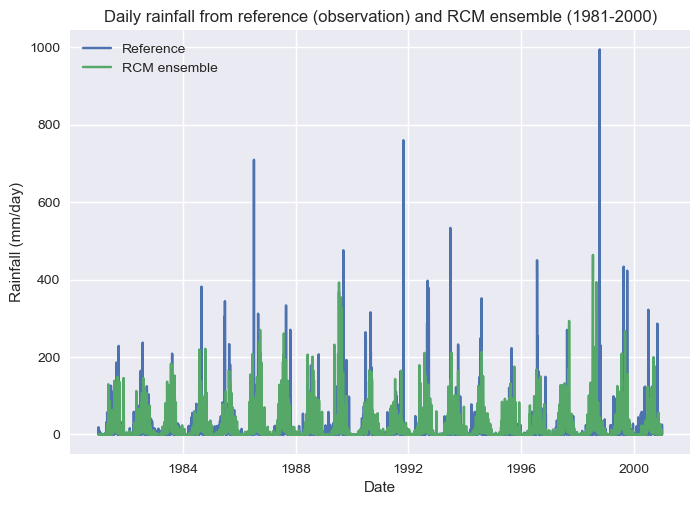

In [38]:
ds = ens_mean.pr.sel(time=slice('1981','2000'))
ds=ds.convert_calendar('gregorian', align_on='year',missing=0)
ref=ref.convert_calendar('gregorian', align_on='year',missing=0)

plt.figure
ax=plt.subplot()
ax.plot(df.date,df.pr, label='Reference')
ax.plot(ds.time,ds, label='RCM ensemble')
plt.ylabel('Rainfall (mm/day)')
plt.xlabel('Date')
plt.title('Daily rainfall from reference (observation) and RCM ensemble (1981-2000)')
plt.legend()

## Applying bias correction algorithms on RCM ensemble
Now observed and climate data is ready for bias correction (BC) {cite}`qm`. Here, 5 BC methods used, empirical quantile mapping (QM), linear scaling (LS), local intensity scaling (LOCI), deterending quantile mapping (DQ), quantile delta mapping (QDM). As following, each of this method are trained on observation and climate data (RCM ensemble) and then applied to adjust data.  

In [49]:
#quantile mapping bias correction
QM_train = sdba.EmpiricalQuantileMapping.train(ref, ds, nquantiles=15, group="time.month", kind="*")
QM_adjust = QM_train.adjust(ds, extrapolation="constant", interp="linear")

#linear scaling mapping bias correction
LS_train = sdba.Scaling.train(ref, ds, group='time.month', kind="*")
LS_adjust = LS_train.adjust(ds)

#local intensity scaling bias correction
LOCI_train = sdba.LOCI.train(ref, ds,thresh='1 mm/day', group="time.month")
LOCI_adjust = LOCI_train.adjust(ds, interp="linear")

#deternding quantile mapping
QD = sdba.DetrendedQuantileMapping.train(ref, ds, nquantiles=15, group="time.month", kind="*")
QD_adjust = QD.adjust(ds, extrapolation="constant", interp="nearest")

#quantile delta mapping
QDM = sdba.QuantileDeltaMapping.train(ref, ds, nquantiles=20, kind="*", group="time.month")
QDM_adjust = QDM.adjust(ds)


/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:449: UserWarning: Using DQM with a grouping other than 'dayofyear' is not recommended (received time.month).
  warn(


## Evaluating bias corrected RCM ensemble
At this stage, all time sereis data from including reference, RCM ensemble, and bias adjusted data are evaluated at daily and monthly time steps. Below shows long term average for each day and month over the historical period, 1981-2000. LS method performs better compared to other methods as can be seen. 

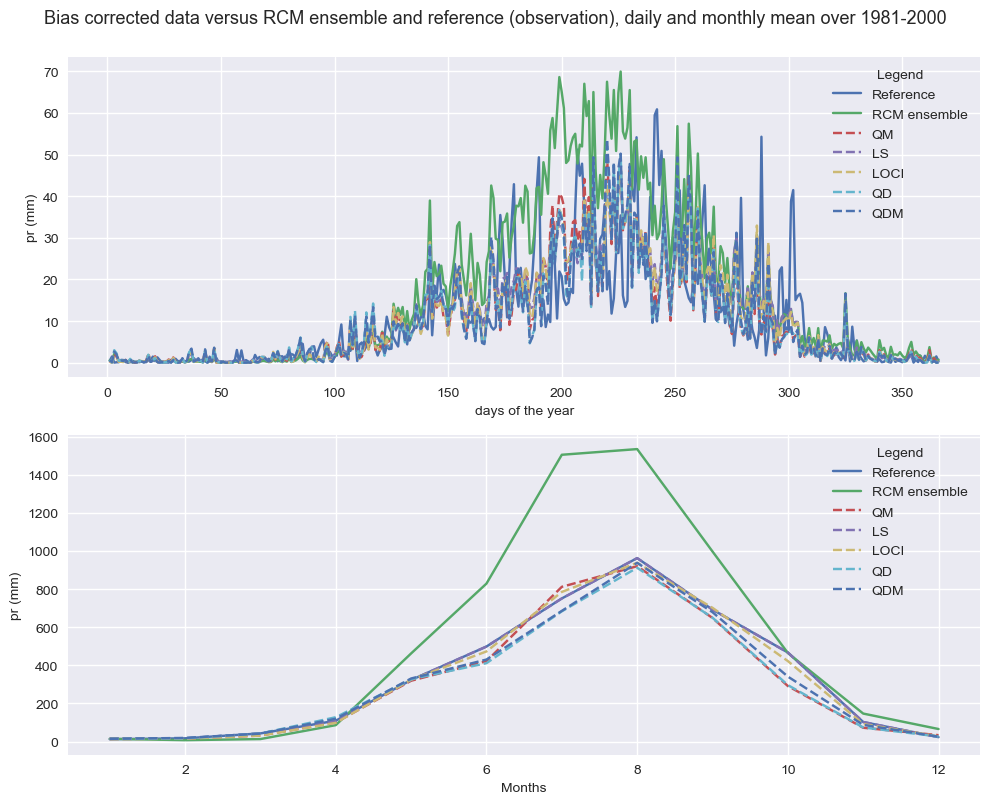

In [40]:
plt.style.use('seaborn')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
fig, axes = plt.subplots(2,1,figsize=(10,8), tight_layout=True)
fig.suptitle('Bias corrected data versus RCM ensemble and reference (observation), daily and monthly mean over 1981-2000',fontsize=13,x=0.5,y=1)

#plot daily average
ref.groupby("time.dayofyear").mean().plot(ax=axes[0], label="Reference")
ds.groupby("time.dayofyear").mean().plot(ax=axes[0], label="RCM ensemble")
QM_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="QM", linestyle="--")
LS_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="LS", linestyle="--")
LOCI_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="LOCI", linestyle="--")
QD_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="QD", linestyle="--")
QDM_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="QDM", linestyle="--")
axes[0].set_ylabel('pr (mm)',fontsize=10)
axes[0].set_xlabel('days of the year',fontsize=10)
axes[0].set_title(None)
axes[0].legend(fontsize=10,title='Legend',title_fontsize=10)

#plot monthly average
(ref.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="Reference")
(ds.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="RCM ensemble")
(QM_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="QM", linestyle="--")
(LS_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="LS", linestyle="--")
(LOCI_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="LOCI", linestyle="--")
(QD_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="QD", linestyle="--")
(QDM_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="QDM", linestyle="--")
axes[1].set_xlabel('Months',fontsize=10)
axes[1].set_ylabel('pr (mm)',fontsize=10)
axes[1].set_title(None)
axes[1].legend(fontsize=10,title='Legend',title_fontsize=10)

## Accuracy assessment of bias corrected RCM ensemble


The accuracy of RCM ensemble versus observed, bias adjusted versus observed time series is evaluated through performance criteria (Objective function). Coefficient of determination (R2) and Pearson r correlations are used to assess data accuracy. To be noted that these metrics are calculated based on monthly time series. When R2 and Pearson r reach close to 1, two datasets show better correlcation. 


In [47]:
criteria=['Coefficient of Determination (R2)','Pearson r']
def error(o,m):
    x = o.resample(time='1m').sum()
    y = m.resample(time='1m').sum()
    r2 = xs.r2(x,y)
    pearson_r = xs.pearson_r(x,y)
    return np.array([r2,pearson_r])

,RCM ensemble,QM,LS,LOCI,QD,QDM
Performance criteria,,,,,,
Coefficient of Determination (R2),-0.31,0.26,0.44,0.36,0.27,0.24
Pearson r,0.68,0.61,0.69,0.65,0.60,0.59


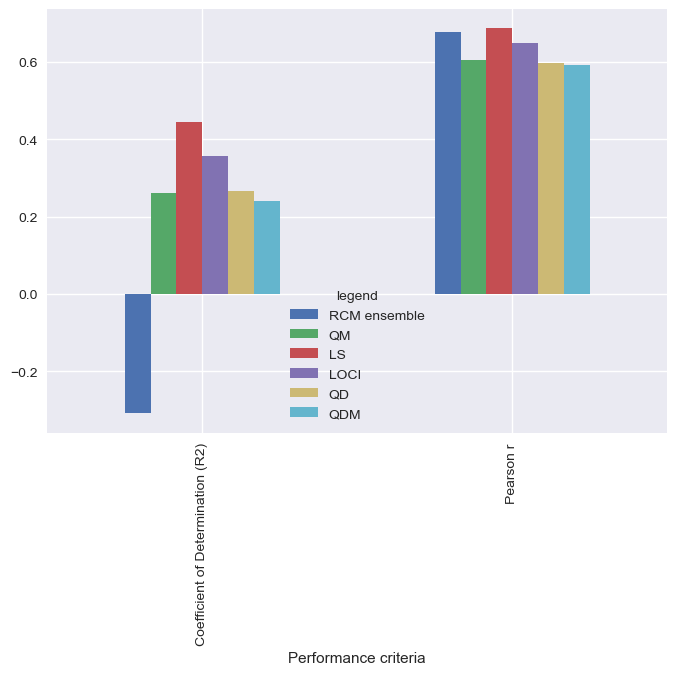

In [50]:
#calculate performance criteria
gcm = error(ref,ds)
qm = error(ref,QM_adjust)
ls = error(ref,LS_adjust)
loci = error(ref,LOCI_adjust)
qd = error(ref,QD_adjust)
qdm = error(ref,QDM_adjust)
#tabulating and plotting data
pd.options.display.float_format = '{:,.2f}'.format
data=pd.DataFrame({'r1':criteria,'RCM ensemble':gcm, 'QM':qm, 'LS':ls, 'LOCI':loci,'QD':qd,'QDM':qdm},columns=['RCM ensemble','QM','LS','LOCI','QD','QDM'],index=criteria).rename_axis('Performance criteria')
data.plot(kind='bar')
plt.legend(title='legend')
data

## Subsetting GCM data
Similary to previous steps, data from CMIP6 model (HadGEM3-GC31-MM) is acquired for the Baguio station. Data is filtered to point of interest and time period, Baguio station from 1981-2000. This data will be referred to as GCM in the successive steps.  

In [27]:
cmip6 = drkz_search(project = 'CMIP6', variable='pr',  source_id = 'HadGEM3-GC31-MM', experiment_id='hist-1950',frequency="day",variant_label = 'r1i1p1f1',nominal_resolution = '100 km')


period=slice('1981','2000') #Define period. 
y=16.4 #Define latitue (baguio station).
x=120.6 #Define longitude (baguio station).
n=34 #no of files/urls to process starting from latest
unit = 'mm/day' #Define the unit for which data to be changed into.
var = 'pr' # Define variable

ds = []
for i in cmip6[len(cmip6)-n:len(cmip6)+1]:
    data = xr.open_dataset(i)
    data=data.sel(lat=y,lon=x, method='nearest') #check metadata of data, change this name (lon/lat) if needed.
    ds.append(data)

ds = xr.concat(ds, dim='time')

ds = xc.units.convert_units_to(ds[var], unit) # changing units
ds = ds.sel(time=period) #slicing data to the period of interest.

ds=ds.convert_calendar('gregorian', align_on='year',missing=0)

http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=HadGEM3-GC31-MM&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=HadGEM3-GC31-MM&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=HadGEM3-GC31-MM&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=HadGEM3-GC31-MM&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
h

/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


## Applying bias correction algorithms on GCM
Similar to previous step, 5 BC methods are applied to remove in GCM, empirical quantile mapping (QM), linear scaling (LS), local intensity scaling (LOCI), deterending quantile mapping (DQ), quantile delta mapping (QDM). As following, each of this method are trained on observation and climate data (GCM) and then applied to adjust data.  

In [28]:
#quantile mapping bias correction
QM_train = sdba.EmpiricalQuantileMapping.train(ref, ds, nquantiles=15, group="time.dayofyear", kind="*")
QM_adjust = QM_train.adjust(ds, extrapolation="constant", interp="linear")

#linear scaling mapping bias correction
LS_train = sdba.Scaling.train(ref, ds, group='time.dayofyear', kind="*")
LS_adjust = LS_train.adjust(ds)

#local intensity scaling bias correction
LOCI_train = sdba.LOCI.train(ref, ds,thresh='1 mm/day', group="time.dayofyear")
LOCI_adjust = LOCI_train.adjust(ds, interp="linear")

#deternding quantile mapping
QD = sdba.DetrendedQuantileMapping.train(ref, ds, nquantiles=15, group="time.month", kind="*")
QD_adjust = QD.adjust(ds, extrapolation="constant", interp="nearest")

#quantile delta mapping
QDM = sdba.QuantileDeltaMapping.train(ref, ds, nquantiles=20, kind="*", group="time.month")
QDM_adjust = QDM.adjust(ds)

/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/farid/Abaconda3/anaco

At this stage, all time sereis data from including reference, GCM, and bias adjusted data are evaluated at daily and monthly time steps. Below shows long term average for each day and month over the historical period, 1981-2000. Emperical quantile mapping method performs better compared to other methods as can be seen. 

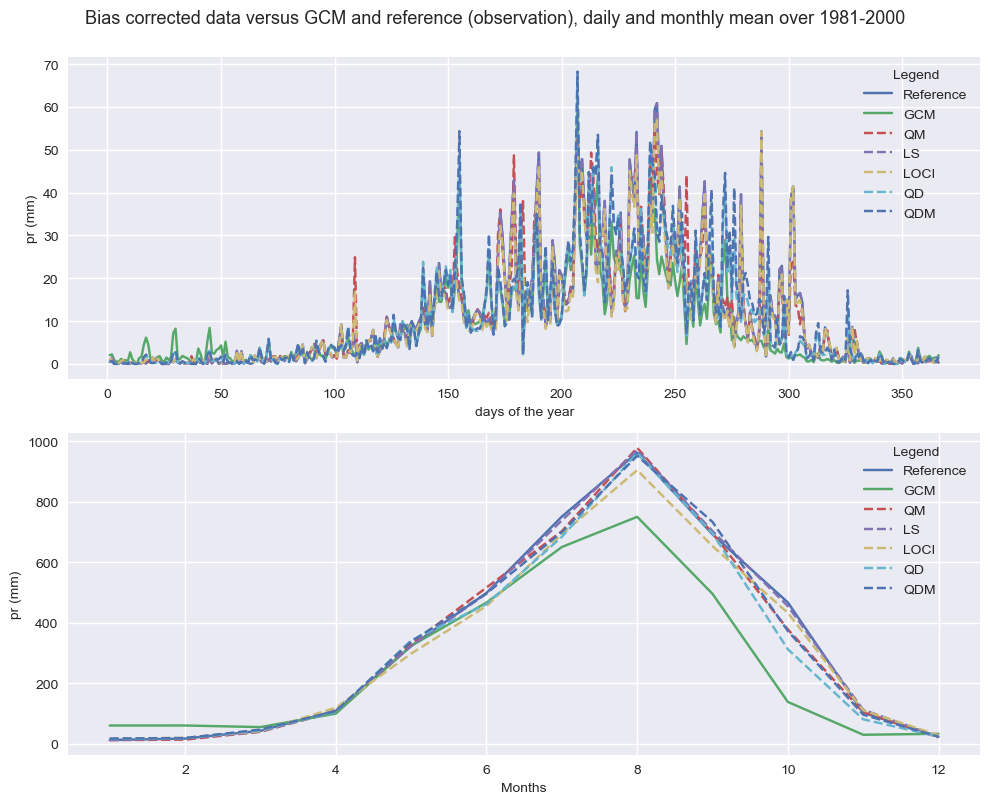

In [29]:
plt.style.use('seaborn')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
fig, axes = plt.subplots(2,1,figsize=(10,8), tight_layout=True)
fig.suptitle('Bias corrected data versus GCM and reference (observation), daily and monthly mean over 1981-2000',fontsize=13,x=0.5,y=1)

#plot daily average
ref.groupby("time.dayofyear").mean().plot(ax=axes[0], label="Reference")
ds.groupby("time.dayofyear").mean().plot(ax=axes[0], label="GCM")
QM_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="QM", linestyle="--")
LS_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="LS", linestyle="--")
LOCI_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="LOCI", linestyle="--")
QD_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="QD", linestyle="--")
QDM_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="QDM", linestyle="--")
axes[0].set_ylabel('pr (mm)',fontsize=10)
axes[0].set_xlabel('days of the year',fontsize=10)
axes[0].set_title(None)
axes[0].legend(fontsize=10,title='Legend',title_fontsize=10)

#plot monthly average
(ref.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="Reference")
(ds.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="GCM")
(QM_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="QM", linestyle="--")
(LS_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="LS", linestyle="--")
(LOCI_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="LOCI", linestyle="--")
(QD_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="QD", linestyle="--")
(QDM_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="QDM", linestyle="--")
axes[1].set_xlabel('Months',fontsize=10)
axes[1].set_ylabel('pr (mm)',fontsize=10)
axes[1].set_title(None)
axes[1].legend(fontsize=10,title='Legend',title_fontsize=10)

## Accuracy assessment of bias corrected GCM
The accuracy of GCM versus observed, bias adjusted versus observed time series is evaluated through performance criteria (Objective function). Coefficient of determination (R2) and Pearson r correlations are used to assess data accuracy. To be noted that these metrics are calculated based on monthly time series. When R2 and Pearson r reach close to 1, two datasets show better correlcation. 

,GCM,QM,LS,LOCI,QD,QDM
Performance criteria,,,,,,
Coefficient of Determination (R2),0.30,0.41,0.39,0.36,0.22,0.18
Pearson r,0.60,0.69,0.67,0.65,0.59,0.58


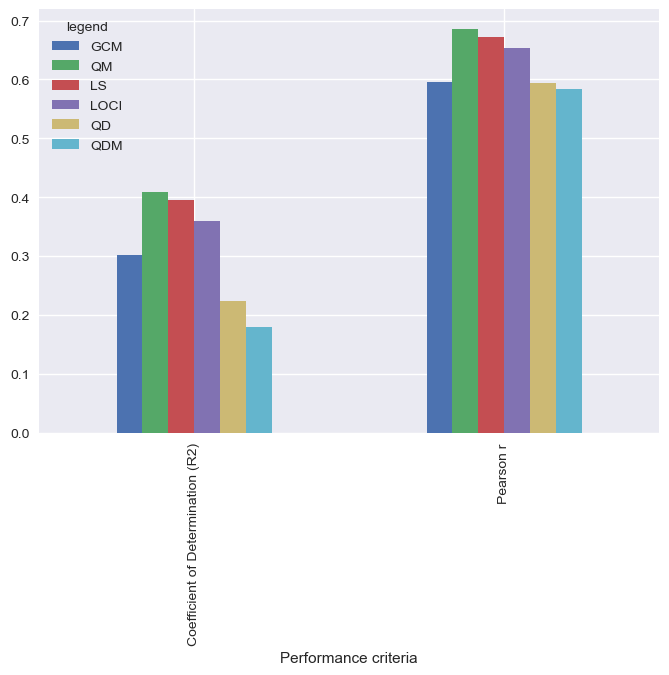

In [30]:
gcm = error(ref,ds)
qm = error(ref,QM_adjust)
ls = error(ref,LS_adjust)
loci = error(ref,LOCI_adjust)
qd = error(ref,QD_adjust)
qdm = error(ref,QDM_adjust)
#tabulating and plotting data
pd.options.display.float_format = '{:,.2f}'.format
data=pd.DataFrame({'r1':criteria,'GCM':gcm, 'QM':qm, 'LS':ls, 'LOCI':loci,'QD':qd,'QDM':qdm},columns=['GCM','QM','LS','LOCI','QD','QDM'],index=criteria).rename_axis('Performance criteria')
data.plot(kind='bar')
plt.legend(title='legend')
data

## Conclusion
The comparison of raw model data from RCM ensemble and GCM suggests that RCM highly overestimate precipitation, while GCM underestimate precipitation. The correlation coefficeient (R2) for RCM ensemble and GCM is -0.2 and 0.3, which suggests that GCM raw data match well with observation when compared to RCM ensemble. It is also to be noted that pearson r shows better performance for RCM ensemble, pearson r for RCM ensemble and GCM is 0.68 and 0.6. 

However, the analysis of bias corrected data from RCM ensemble and GCM shows an oppsite trend. The bias correction of RCM ensemble revealed that linear scaling (LS) performed well compared to other methods, R2 is 0.44 and pearson r is 0.69. Bias corrected GCM data showed that emporical quantile mapping (QM) performed better compared to other methods, R2 is 0.41 and pearson r is 0.69. 

## References

```{bibliography}
:style: plain
```